# CAX: Cellular Automata Accelerated in JAX [![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/maxencefaldor/cax/blob/main/examples/00_getting_started.ipynb) [![Paper](http://img.shields.io/badge/paper-arxiv.2410.02651-B31B1B.svg)](https://arxiv.org/abs/2410.02651)

CAX is a high-performance and flexible open-source library designed to **accelerate artificial life research**. 🧬

## Abstract

Cellular automata have become a cornerstone for investigating emergence and self-organization across diverse scientific disciplines. However, the absence of a hardware-accelerated cellular automata library limits the exploration of new research directions, hinders collaboration, and impedes reproducibility. In this work, we introduce CAX (Cellular Automata Accelerated in JAX), a high-performance and flexible open-source library designed to accelerate cellular automata research. CAX delivers cutting-edge performance through hardware acceleration while maintaining flexibility through its modular architecture, intuitive API, and support for both discrete and continuous cellular automata in arbitrary dimensions. We demonstrate CAX's performance and flexibility through a wide range of benchmarks and applications. From classic models like elementary cellular automata and Conway's Game of Life to advanced applications such as growing neural cellular automata and self-classifying MNIST digits, CAX speeds up simulations up to 2,000 times faster. Furthermore, we demonstrate CAX's potential to accelerate research by presenting a collection of three novel cellular automata experiments, each implemented in just a few lines of code thanks to the library's modular architecture. Notably, we show that a simple one-dimensional cellular automaton can outperform GPT-4 on the 1D-ARC challenge.

![Self-autoencoding MNIST Digits](../docs/ca_types.png)

## Installation

You will need Python 3.10 or later, and a working JAX installation. For example, you can install JAX with:

In [ ]:
%pip install -U "jax[cuda12]"

Then, install CAX from PyPi:

In [ ]:
%pip install -U "cax[examples]"

## Import

In [ ]:
import jax
import jax.numpy as jnp
import mediapy
from flax import nnx

## Cellular Automata

A *cellular automaton* is a simple model of computation consisting of a regular grid of cells, each in a particular state. The grid can be in any finite number of dimensions. For each cell, a set of cells called its *neighborhood* is defined relative to the specified cell. The grid is updated at discrete time steps according to a fixed rule that determines the new state of each cell based on its current state and the states of the cells in its neighborhood.

## CAX Architecture

CAX introduces a unifying framework for *all cellular automata types*. This flexible architecture is
built upon two key components: the **perceive** module and the **update** module. Together, these modules define the local rule of the CA. At each time step, this local rule is applied uniformly to all cells in the grid, generating the next global state of the system.

![CAX architecture](../docs/architecture.png)

Figure adapted from "Growing Neural Cellular Automata", Mordvintsev et al. (2020), under CC-BY 4.0 license.

CAX's architecture introduces the novel concept of **Controllable Cellular Automata** that extend the capabilities of traditional CAs by making them responsive to external inputs, akin to recurrent neural networks processing sequential data, see Figure above. Controllable cellular automata bridge the gap between recurrent convolutional neural networks and cellular automata, opening up new possibilities for modeling complex systems that exhibit both autonomous emergent behavior and responsiveness to external control.

For CA experiments with external inputs, see [examples/41_growing_conditional_nca.ipynb](../examples/41_growing_conditional_nca.ipynb) and [examples/42_growing_unsupervised_nca.ipynb](../examples/42_growing_unsupervised_nca.ipynb) for example.

## Let's dive in

In this notebook, we will explore how to use CAX to both:
- instantiate classic cellular automata like the Game of Life and
- create custom cellular automata from scratch.

You'll learn the fundamental concepts and implementation techniques that make CAX a powerful framework for cellular automata experimentation.

## Use existing cellular automata

In this section, we'll demonstrate the basic usage of CAX with pre-implemented cellular automata. We'll instantiate Conway's Game of Life and visualize a glider pattern, showing how easily you can get started with existing models in the library.

### Configuration

In [5]:
seed = 0

spatial_dims = (32, 32)

num_steps = 128

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

### Init state

In [6]:
def init_state():
	state = jnp.zeros((*spatial_dims, 1))

	mid_x, mid_y = spatial_dims[0] // 2, spatial_dims[1] // 2
	glider = jnp.array(
		[
			[0.0, 1.0, 0.0],
			[0.0, 0.0, 1.0],
			[1.0, 1.0, 1.0],
		]
	)
	return state.at[mid_x : mid_x + 3, mid_y : mid_y + 3, 0].set(glider)

### Model

In [9]:
from cax.models.life import Life

ca = Life(rngs=rngs)

### Visualize

Run the cellular automata for 256 steps.

In [ ]:
state = init_state()

states = ca(state, num_steps=num_steps, all_steps=True)

""

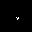

In [11]:
states = jnp.concatenate([state[None], states])
frames = jax.vmap(ca.render)(states)

mediapy.show_video(frames, width=256, height=256, codec="gif")

## Create your own cellular automata from scratch

In this section, we will build a cellular automaton from scratch using custom Perceive and Update modules. We'll implement a small neural cellular automaton featuring convolutional perception and residual update mechanisms. Note that we won't be training this neural cellular automaton in the current notebook - we'll focus solely on its construction and architecture.

### Configuration

In [2]:
seed = 0

num_spatial_dims = 2
channel_size = 16
num_kernels = 3
hidden_size = 128
cell_dropout_rate = 0.5

key = jax.random.key(seed)
rngs = nnx.Rngs(seed)

### Perceive

CAX provides a set of perceive models. In this notebook, we will use a simple convolution perceive module.

In [3]:
from cax.core.perceive import ConvPerceive

perceive = ConvPerceive(
	channel_size=channel_size,  # Number of channels per cell in the grid
	perception_size=2 * channel_size,  # Number of channels per cell in the perception
	rngs=rngs,
)

### Update

CAX provides a set of update models. In this notebook, we will use a residual MLP update module.

In [4]:
from cax.core.update import ResidualUpdate

update = ResidualUpdate(
	num_spatial_dims=2,  # Number of spatial dimensions
	channel_size=channel_size,  # Number of channels per cell in the grid
	perception_size=2 * channel_size,  # Number of channels per cell in the perception
	hidden_layer_sizes=(hidden_size,),  # Sizes of hidden layers in the MLP
	rngs=rngs,
)

### Cellular Automata

The final step to create the cellular automata is to combine the perceive and update modules.

In [5]:
from cax.core.ca import CA

ca = CA(perceive, update)

### Init state

""

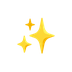

In [6]:
from cax.utils.emoji import get_emoji

target = get_emoji("✨", size=40, padding=16)

mediapy.show_image(target)

In [7]:
def init_state():
	state_shape = target.shape[:2] + (channel_size,)
	state = jnp.zeros(state_shape)

	# Set the target image in the RGB channels
	return state.at[:, :, :4].set(target)

### Visualize

Run the cellular automata for 256 steps.

In [8]:
state = init_state()

states = ca(state, num_steps=256, all_steps=True)

Clip the states to display as a video.

In [9]:
states = jnp.clip(jnp.concatenate([state[None], states]), min=0.0, max=1.0)

Now you know how to run cellular automata with CAX! Go through the other notebooks to understand how to run classic cellular automata such as Game of Life or Lenia, or train neural cellular automata such as growing neural cellular automata.


""

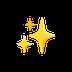

In [12]:
mediapy.show_video(states[..., :3], width=256, height=256, codec="gif")